# Segmentation of Indian Traffic

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [ ]:
!wget --header="Host: doc-04-c0-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://mail.google.com/" --header="Cookie: AUTH_haaj2uhu44td69am06nrf1t1e62n27c9_nonce=501f01tr7q2as" --header="Connection: keep-alive" "https://doc-04-c0-docs.googleusercontent.com/docs/securesc/n1bsi7509639no0derjjee7nq76sdpad/fl8pb52bt5p1uqm6531nugu49k1mi5n6/1645123200000/00484516897554883881/12966751109160138268/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0&nonce=501f01tr7q2as&user=12966751109160138268&hash=hcli9n3d87p1ekpfqgfo0e178ovaqr5g" -c -O 'data.zip'

--2022-02-17 18:42:15--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/n1bsi7509639no0derjjee7nq76sdpad/fl8pb52bt5p1uqm6531nugu49k1mi5n6/1645123200000/00484516897554883881/12966751109160138268/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0&nonce=501f01tr7q2as&user=12966751109160138268&hash=hcli9n3d87p1ekpfqgfo0e178ovaqr5g
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connecting to doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)|173.194.218.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2339740971 (2.2G) [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.18G  72.7MB/s    in 25s     

2022-02-17 18:42:41 (88.9 MB/s) - ‘data.zip’ saved [2339740971/2339740971]



<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

In [ ]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("./")

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    list_files=[]
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    images_dir = os.listdir(os.path.join(root_dir,'images'))
    images = []
    json = []
    for dirt in images_dir:
        for image_file in os.listdir(os.path.join(root_dir, 'images', dirt)):
            im = os.path.join(root_dir,'images', dirt, image_file)
            ids = re.findall("([0-9].*?)_", im)
            path = root_dir+'/mask/'+ ids[0] + '_gtFine_polygons.json'
            js = path
            list_files.append([im, js])
    df = pd.DataFrame(list_files, columns = ['image', 'json'])
    return df

# for i, j in zip(range(x), range(y)):

In [ ]:
root_dir='data'
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/313/frame0659_leftImg8bit.jpg,data/mask/313/frame0659_gtFine_polygons.json
1,data/images/313/frame0179_leftImg8bit.jpg,data/mask/313/frame0179_gtFine_polygons.json
2,data/images/313/frame0419_leftImg8bit.jpg,data/mask/313/frame0419_gtFine_polygons.json
3,data/images/369/frame0246_leftImg8bit.jpg,data/mask/369/frame0246_gtFine_polygons.json
4,data/images/370/frame2276_leftImg8bit.jpg,data/mask/370/frame2276_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    lst_obj=[]
    for file in data_df['json']:
        f = open (file, "r")
        data = json.load(f)
        for obj in data['objects']:
            lst_obj.append(obj['label'])
            
    unique_labels = set(lst_obj)
            
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("False")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    label=[]
    vertexlist=[]
    f = open (file, "r")
    data = json.load(f)
    w= data['imgWidth']
    h=data['imgHeight']
    for obj in data['objects']:
        vertices=[]
        lb = obj['label']
        label.append(lb)
        for vertex in obj['polygon']:
            vertices.append(tuple(vertex))
        vertexlist.append(vertices)

    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

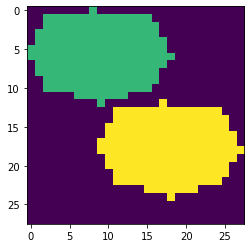

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
#https://www.geeksforgeeks.org/python-copy-directory-structure-without-files/
#copying file structure of mask folder to output folder for storing mask images
import shutil
 
# importing the os module
import os
 
# defining the function to ignore the files
# if present in any folder
def ignore_files(dir, files):
    return [f for f in files if os.path.isfile(os.path.join(dir, f))]
 
# calling the shutil.copytree() method and
# passing the src,dst,and ignore parameter
shutil.copytree('data/mask',
                'data/output',
                ignore=ignore_files)

'data/output'

In [ ]:
from tqdm import tqdm
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    
    path_lst=[]   
    #iterating over every image in the dataframe
    for i in tqdm(range(len(data_df))):
        #getting image info using get_poly()
        w, h, labels, vertexlist = get_poly(data_df['json'][i])
        #creating a new rgb image
        img = Image.new("RGB", (w, h))
        #plotting the polygon of labels associated with an object and filling values corresponding to the labels given above 
        for j in range(len(vertexlist)):
            if len(vertexlist[j])>1:
                img1 = ImageDraw.Draw(img)
                img1.polygon(vertexlist[j], fill = label_clr[labels[j]])
        #converting image to numpy array
        img=np.array(img)
        #extracting only the first channel values
        im = Image.fromarray(img[:,:,0])
        #saving the first channel values as image(mask)
        path = data_df['json'][i].replace('mask','output')
        path = path.replace('json','png')
        im.save(path)
        #stroring the file path of each mask
        path_lst.append(path)
    #appending the maskz images file path to data_df
    data_df['mask']=path_lst
    
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:27<00:00, 14.99it/s]


,image,json,mask
0,data/images/313/frame0659_leftImg8bit.jpg,data/mask/313/frame0659_gtFine_polygons.json,data/output/313/frame0659_gtFine_polygons.png
1,data/images/313/frame0179_leftImg8bit.jpg,data/mask/313/frame0179_gtFine_polygons.json,data/output/313/frame0179_gtFine_polygons.png
2,data/images/313/frame0419_leftImg8bit.jpg,data/mask/313/frame0419_gtFine_polygons.json,data/output/313/frame0419_gtFine_polygons.png
3,data/images/369/frame0246_leftImg8bit.jpg,data/mask/369/frame0246_gtFine_polygons.json,data/output/369/frame0246_gtFine_polygons.png
4,data/images/370/frame2276_leftImg8bit.jpg,data/mask/370/frame2276_gtFine_polygons.json,data/output/370/frame2276_gtFine_polygons.png


In [ ]:
#saving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
data_df=pd.read_csv('preprocessed_data.csv')

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

1. The objective in the image segmentation tasks is to get the geometric shapes of the objects inside the image. In other words we are interested in capturing the edges in the image or the outline of various objects in the image so that we can easily identify each object inside the image.

2. If we consider all the edges to me marked as 1 and the other backgrounds as 0 then there is a significant class imbalance in the data with class 0 being the majority class.The results might be appealing when calculating the loss/performance using categorical cross entropy but they are unable to get the global view i.e. they are only capable of calculating the pixel wise loss of the image. As a result we are unable to get clear and distinct boundaries of objects in the image. 

3. This is where loss function like IOU and dice loss have an advantage over the other loss functions.


* Formulation of Dice coeffecient

![image.png](attachment:image.png)

- In the formulation we can observe that the value of L increase only when the predicted and actual values are same(as it is the product of both values where value can either be 0 or 1). Through this formulation we can observe that dice loss is able to perform better in case of class imbalance and is able to penalize the error caused by the model due to class imbalance. As a result the edges can be detected more accurately by the model on further training of the model.

* Range of Dice coeffecient

- Since the denominator consist of sum of all the edges in the predicted and actual images therefore we can conclude that the range of dice loss is between 0 and 1. 

4. Dice loss tries to calculate the overlap between the actual image and the predicted image. 
![image-2.png](attachment:image-2.png)

5. In boundary detection tasks the ground truth boundary pixels and predicted boundary pixels can be viewed as two sets. 
   By leveraging Dice loss, the two sets are trained to overlap little by little. 
   The denominator considers the total number of boundary pixels at global scale, while the numerator considers
   the overlap between the two sets at local scale. Therefore, Dice loss considers the loss information both locally and            globally which is critical for high accuracy.

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df, test_size=0.15)

In [ ]:
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 1.2 MB/s            


In [ ]:
import os
import tensorflow as tf
import keras
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = 'tf.keras'
import segmentation_models as sm
from segmentation_models import Unet

Segmentation Models: using `tf.keras` framework.


In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(128,128,3))

2022-02-17 18:48:27.381699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 18:48:27.469376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 18:48:27.470057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 18:48:27.471294: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

85532672/85521592 [==============================] - 4s 0us/step


In [ ]:
import imgaug.augmenters as iaa
aug2 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [ ]:
CLASSES = list(np.unique(list(label_clr.values())))
CLASSES = [class1//10 for class1 in CLASSES]

In [ ]:
# def visualize(**images):
#     n = len(images)
#     plt.figure(figsize=(16, 5))
#     for i, (name, image) in enumerate(images.items()):
#         plt.subplot(1, n, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(' '.join(name.split('_')).title())
#         if i==1:
#             plt.imshow(image, cmap='gray', vmax=1, vmin=0)
#         else:
#             plt.imshow(image)
#     plt.show()
    
# def normalize_image(mask):
#     mask = mask/255
#     return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = CLASSES 
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and mask will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, data, classes):
        
        self.ids = data
        # the paths of images
        self.images_fps   = [image for image in data.iloc[:,0]]
        # the paths of segmentation images
        self.masks_fps    = [mask for mask in data.iloc[:,1]]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
#         image_mask = normalize_image(mask)

        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.25:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.50:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.75:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        else :
            image = aug5.augment_image(image)
            image_mask = image_mask
            
        image = cv2.resize(image, (128,128),
               interpolation = cv2.INTER_NEAREST)
        
        image_mask = cv2.resize(image_mask, (128, 128),
               interpolation = cv2.INTER_NEAREST)

        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=4, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
            
        
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import IOUScore
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.0001)

# focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, total_loss, metrics=[IOUScore(threshold = 0.5)])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [ ]:
# Dataset for train images

CLASSES = list(np.unique(list(label_clr.values())))
CLASSES = [class1//10 for class1 in CLASSES]
train_dataset = Dataset(X_train[['image','mask']], classes=CLASSES)
test_dataset  = Dataset(X_test[['image','mask']], classes=CLASSES)
BATCH_SIZE=4
train_dataloader = Dataloder(train_dataset, batch_size=4, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=4, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128, 128, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 1)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
]

(4, 128, 128, 3)


In [ ]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=8,\
                              validation_data=test_dataloader,callbacks=callbacks)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-02-17 18:48:48.182210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8


2022-02-17 18:48:57.483679: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


851/851 [==============================] - 3801s 4s/step - loss: 0.9448 - iou_score: 0.8831 - val_loss: 0.9336 - val_iou_score: 0.9167


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/8
851/851 [==============================] - 3745s 4s/step - loss: 0.9294 - iou_score: 0.9184 - val_loss: 0.9267 - val_iou_score: 0.9151
Epoch 3/8
851/851 [==============================] - 3773s 4s/step - loss: 0.9263 - iou_score: 0.9019 - val_loss: 0.9244 - val_iou_score: 0.9121
Epoch 4/8
851/851 [==============================] - 3663s 4s/step - loss: 0.9235 - iou_score: 0.8744 - val_loss: 0.9247 - val_iou_score: 0.8764
Epoch 5/8
851/851 [==============================] - 3724s 4s/step - loss: 0.9221 - iou_score: 0.8659 - val_loss: 0.9232 - val_iou_score: 0.8661
Epoch 6/8
851/851 [==============================] - 3748s 4s/step - loss: 0.9207 - iou_score: 0.8725 - val_loss: 0.9229 - val_iou_score: 0.8692
Epoch 7/8
851/851 [==============================] - 3775s 4s/step - loss: 0.9199 - iou_score: 0.8748 - val_loss: 0.9239 - val_iou_score: 0.8670
Epoch 8/8
851/851 [==============================] - 3875s 5s/step - loss: 0.9169 - iou_score: 0.8753 - val_loss: 0.9216 - val_iou

In [ ]:
import matplotlib.pyplot as plt

from PIL import Image
import numpy
X_test.reset_index(inplace=True,drop= True)
def plot_image(index):
    image =  X_test['image'][index]
    image = cv2.imread(image)
    image = cv2.resize(image,(128,128),interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_mask = X_test['mask'][index]
    img_mask = Image.open(image_mask)

    image_array = np.array(image)
    pred_mask = model.predict(image_array[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)

    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(img_mask)
    plt.subplot(133)
    plt.imshow(pred_mask[0])

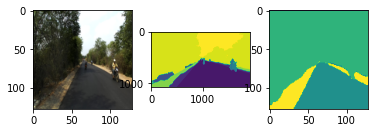

In [ ]:
plot_image(0)

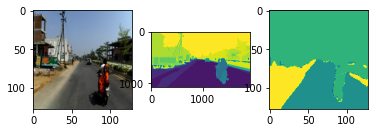

In [ ]:
plot_image(10)

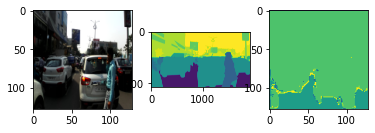

In [ ]:
plot_image(20)

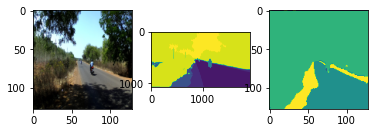

In [ ]:
plot_image(5)

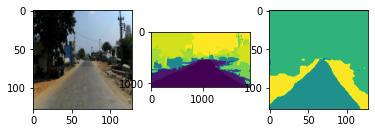

In [ ]:
plot_image(69)

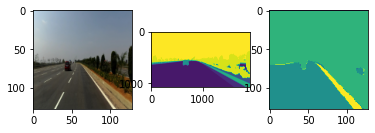

In [ ]:
plot_image(50)

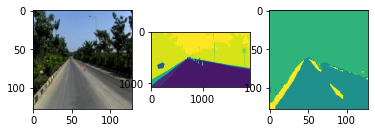

In [ ]:
plot_image(100)